## Import Library

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pemisahan Dataset dan Augmentasi Data



In [3]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train_mclahe'
val_dir = '/content/drive/MyDrive/PI/valid_mclahe'
test_dir = '/content/drive/MyDrive/PI/test_mclahe'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,             # Lebih kecil untuk mempertahankan konteks
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

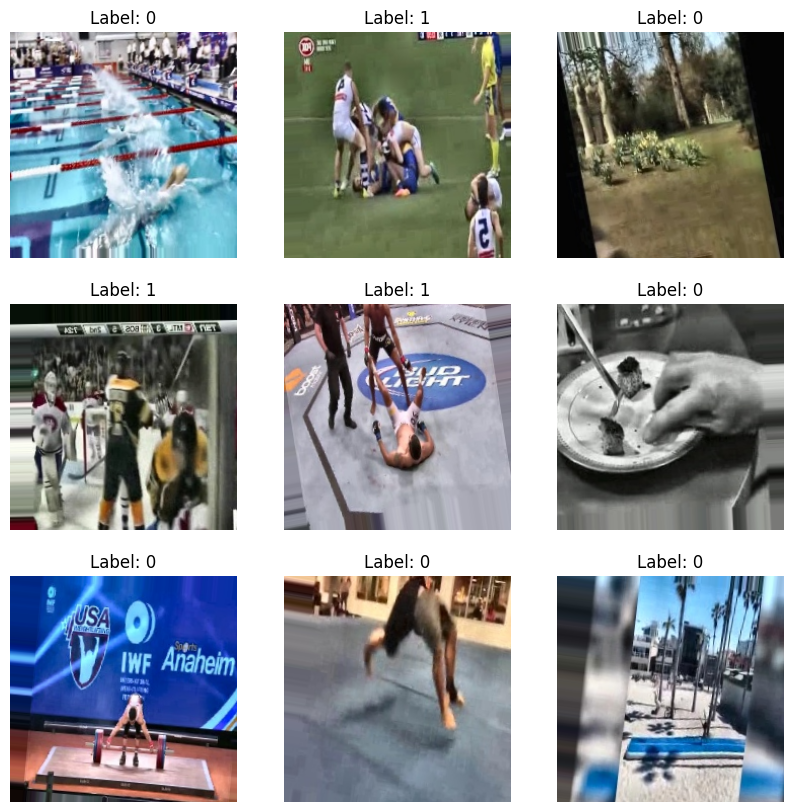

In [4]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [5]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 40
for layer in base_model.layers[:40]:
    layer.trainable = False
for layer in base_model.layers[40:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'MCLAHE_Freeze40_0.01.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [6]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7174 - loss: 1.3852
Epoch 1: val_accuracy improved from -inf to 0.67500, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 482s 10s/step - accuracy: 0.7189 - loss: 1.3824 - val_accuracy: 0.6750 - val_loss: 1.4535
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8341 - loss: 0.9346
Epoch 2: val_accuracy improved from 0.67500 to 0.80227, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.8342 - loss: 0.9336 - val_accuracy: 0.8023 - val_loss: 0.8619
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8820 - loss: 0.6549
Epoch 3: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - accuracy: 0.8818 - loss: 0.6547 - val_accuracy: 0.7523 - val_loss: 0.8037
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8946 - loss: 0.6045
Epoch 4: val_accuracy did not improve from 0.80227
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.8942 - loss: 0.6052 - val_accuracy: 0.6409 - val_loss: 1.2045
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8593 - loss: 0.6976
Epoch 5: val_accuracy improved from 0.80227 to 0.83409, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 573ms/step - accuracy: 0.8594 - loss: 0.6978 - val_accuracy: 0.8341 - val_loss: 0.7700
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8447 - loss: 0.7280
Epoch 6: val_accuracy improved from 0.83409 to 0.87955, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - accuracy: 0.8449 - loss: 0.7277 - val_accuracy: 0.8795 - val_loss: 0.7223
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8663 - loss: 0.7439
Epoch 7: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 554ms/step - accuracy: 0.8663 - loss: 0.7440 - val_accuracy: 0.8068 - val_loss: 0.8737
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8760 - loss: 0.7517
Epoch 8: val_accuracy did not improve from 0.87955
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 539ms/step - accuracy: 0.8757 - loss: 0.7535 - val_accuracy: 0.8114 - val_loss: 1.1165
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8713 - loss: 0.8838
Epoch 9: val_accuracy improved from 0.87955 to 0.88409, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 563ms/step - accuracy: 0.8713 - loss: 0.8832 - val_accuracy: 0.8841 - val_loss: 0.7717
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8661 - loss: 0.8045
Epoch 10: val_accuracy improved from 0.88409 to 0.88864, saving model to MCLAHE_Freeze40_0.01.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.8663 - loss: 0.8045 - val_accuracy: 0.8886 - val_loss: 0.7806
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.8675 - loss: 0.9257
Epoch 11: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.8676 - loss: 0.9264 - val_accuracy: 0.8091 - val_loss: 1.1509
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8677 - loss: 0.9521
Epoch 12: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.8679 - loss: 0.9510 - val_accuracy: 0.8000 - val_loss: 0.9998
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8868 - loss: 0.8466
Epoch 13: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 564ms/step - accuracy: 0.8867 - loss: 0.8474 - val_accuracy: 0.8455 - val_loss: 0.9730
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8981 - loss: 0.7919
Epoch 14: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 563ms/step - accuracy: 0.8843 - loss: 0.7695 - val_accuracy: 0.8909 - val_loss: 0.6971
Epoch 20/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8828 - loss: 0.6852
Epoch 20: val_accuracy did not improve from 0.89091
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.8826 - loss: 0.6857 - val_accuracy: 0.8773 - val_loss: 0.6577
Epoch 21/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8590 - loss: 0.6633
Epoch 21: val_accuracy did not improve from 0.89091
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.8593 - loss: 0.6629 - val_accuracy: 0.7795 - val_loss: 0.8525
Epoch 22/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.8859 - loss: 0.5809
Epoch 22: val_accuracy did not improve from 0.89091
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.8859 - loss: 0.5811 - val_accuracy: 0.8909 - val_loss: 0.5322
Epoch 23/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.8875 - loss: 0.5735
Epoch 23: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 560ms/step - accuracy: 0.8833 - loss: 0.5735 - val_accuracy: 0.8955 - val_loss: 0.5167
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8860 - loss: 0.5376
Epoch 28: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.8859 - loss: 0.5376 - val_accuracy: 0.8727 - val_loss: 0.5533
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8821 - loss: 0.4977
Epoch 29: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 557ms/step - accuracy: 0.8820 - loss: 0.4980 - val_accuracy: 0.7932 - val_loss: 0.7419
Epoch 30/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8724 - loss: 0.5436
Epoch 30: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 551ms/step - accuracy: 0.8726 - loss: 0.5433 - val_accuracy: 0.8182 - val_loss: 0.6553
Epoch 31/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8849 - loss: 0.5123
Epoch 31: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8157 - loss: 0.9822
Validation Loss: 2.2516727447509766
Validation Accuracy: 0.5386363863945007


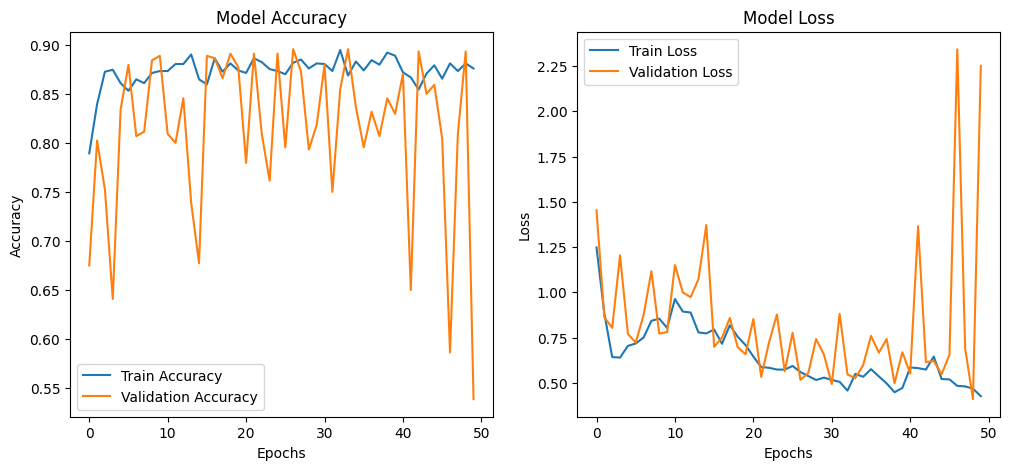

In [7]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [8]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('MCLAHE_Freeze40_0.01.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 53s 9s/step - accuracy: 0.8452 - loss: 0.5771
Test Accuracy : 87.84%
Test Loss     : 0.519


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 263ms/step


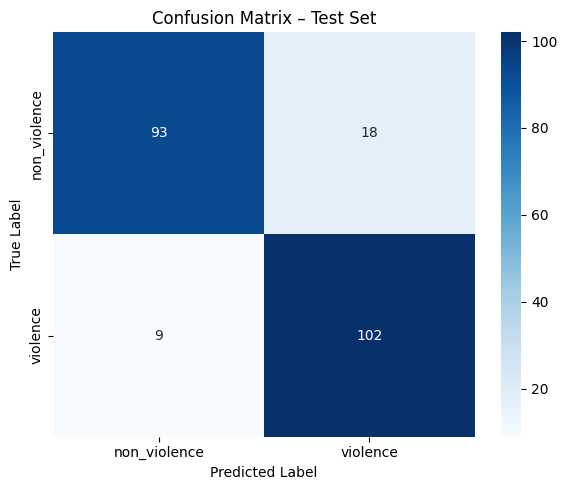


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.91      0.84      0.87       111
    violence       0.85      0.92      0.88       111

    accuracy                           0.88       222
   macro avg       0.88      0.88      0.88       222
weighted avg       0.88      0.88      0.88       222



In [9]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))